In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import  stopwords
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost

In [2]:
train_data =pd.read_csv('train.csv')
train_data

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


#### before we start here are some assumption :
    
####    In every columns :    0 = NO  , 1 = YES

In [3]:
train_data.shape

(159571, 8)

In [4]:
train_data.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [5]:
train_data.dtypes

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

In [6]:
train_data.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train_data['malignant'].value_counts()

0    144277
1     15294
Name: malignant, dtype: int64

In [9]:
train_data['highly_malignant'].value_counts()

0    157976
1      1595
Name: highly_malignant, dtype: int64

In [10]:
train_data['rude'].value_counts()

0    151122
1      8449
Name: rude, dtype: int64

In [11]:
train_data['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [12]:
train_data['abuse'].value_counts()

0    151694
1      7877
Name: abuse, dtype: int64

In [13]:
train_data['loathe'].value_counts()

0    158166
1      1405
Name: loathe, dtype: int64

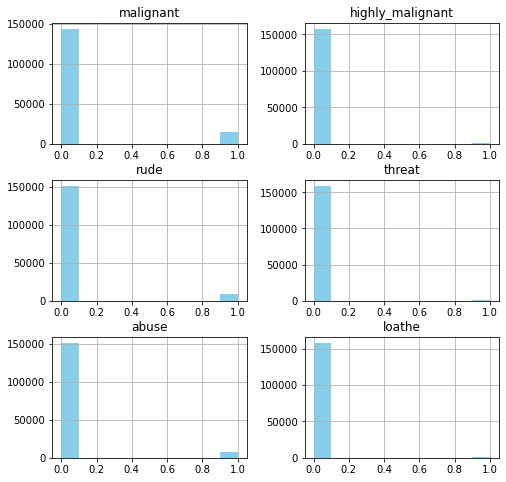

In [15]:
train_data.hist(color ="skyblue" , figsize =(8,8))
plt.show()

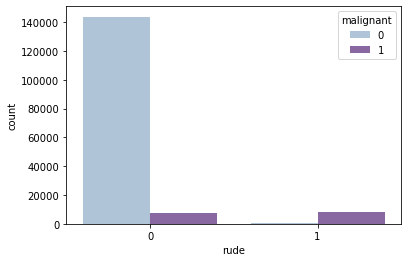

In [16]:
sns.countplot(x='rude', hue='malignant' ,palette="BuPu",data =train_data)
plt.show()

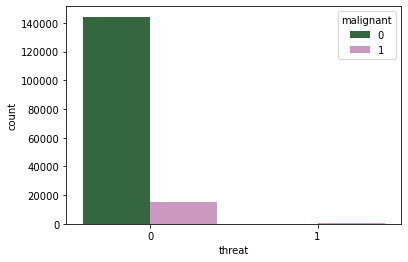

In [17]:
sns.countplot(x='threat', hue='malignant' ,palette="cubehelix",data =train_data)
plt.show()

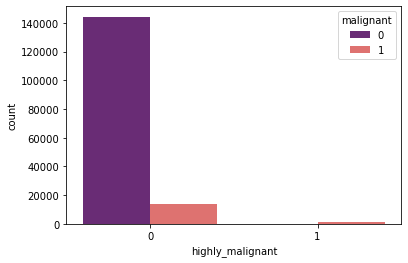

In [18]:
sns.countplot(x='highly_malignant', hue='malignant' ,palette="magma",data =train_data)
plt.show()

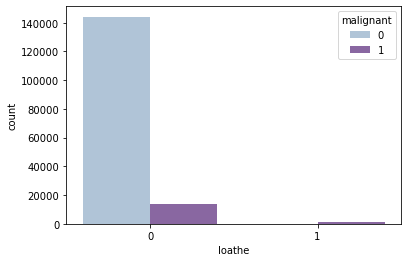

In [19]:
sns.countplot(x='loathe', hue='malignant',palette="BuPu" ,data =train_data)
plt.show()

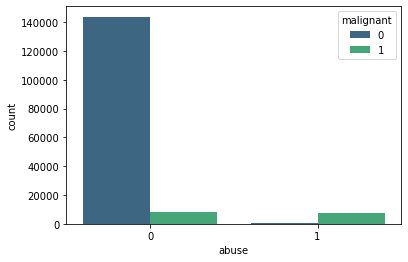

In [20]:
sns.countplot(x='abuse', hue='malignant' ,palette="viridis",data =train_data)
plt.show()

In [21]:
train_data.skew()

malignant            2.745854
highly_malignant     9.851722
rude                 3.992817
threat              18.189001
abuse                4.160540
loathe              10.515923
dtype: float64

In [23]:
train_data['comment_text'].value_counts()

Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [24]:
# Convert all messages to lower case
train_data['comment_text'] = train_data['comment_text'].str.lower()

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
train_data['comment_text'] = train_data['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

# Replace email addresses with 'email'
train_data['comment_text'] = train_data['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
train_data['comment_text'] = train_data['comment_text'].str.replace(r'£|\$', 'dollers')
    
# Replace URLs with 'webaddress'
train_data['comment_text'] = train_data['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

In [26]:
train_data['comment_text'] = train_data['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

train_data['comment_text'] = train_data['comment_text'].apply(lambda x: ' '.join(term for term in x.split() if term not in string.punctuation))

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

lem=WordNetLemmatizer()
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

In [29]:
cols_target = ['malignant','highly_malignant','rude','threat','abuse','loathe']
df_distribution = train_data[cols_target].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

In [30]:
target_data = train_data[cols_target]

train_data['bad'] =train_data[cols_target].sum(axis =1)
print(train_data['bad'].value_counts())
train_data['bad'] = train_data['bad'] > 0 
train_data['bad'] = train_data['bad'].astype(int)

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: bad, dtype: int64


In [32]:
#  Convert text into vectors using TF-IDF


tf_vec = TfidfVectorizer(max_features = 10000, stop_words='english')
features = tf_vec.fit_transform(train_data['comment_text'])
x = features

In [33]:
test_data =pd.read_csv('test.csv')
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [34]:
y=train_data['bad']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=0)

In [35]:
# LogisticRegression

lr = LogisticRegression(C=1, max_iter = 3000)

lr.fit(x_train, y_train)

y_pred_train = lr.predict(x_train)
print('Training accuracy     :',format(accuracy_score(y_train, y_pred_train)))
print('-'*50)
y_pred_test = lr.predict(x_test)
print('Test accuracy         :',format(accuracy_score(y_test,y_pred_test)))
print('-'*50)
print('confusion matrix      :',confusion_matrix(y_test,y_pred_test))
print('-'*50)
print('Classification Report :',classification_report(y_test,y_pred_test))

Training accuracy     : 0.9598138747884941
--------------------------------------------------
Test accuracy         : 0.9561961460128466
--------------------------------------------------
confusion matrix      : [[28458   152]
 [ 1246  2059]]
--------------------------------------------------
Classification Report :               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28610
           1       0.93      0.62      0.75      3305

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915



In [36]:
#AdaBoostClassifier

ada =AdaBoostClassifier(n_estimators=100)

ada.fit(x_train, y_train)

y_pred_train = ada.predict(x_train)
print('Training accuracy     :',format(accuracy_score(y_train, y_pred_train)))
print('-'*50)
y_pred_test = ada.predict(x_test)
print('Test accuracy         :',format(accuracy_score(y_test,y_pred_test)))
print('-'*50)
print('confusion matrix      :',confusion_matrix(y_test,y_pred_test))
print('-'*50)
print('Classification Report :',classification_report(y_test,y_pred_test))

Training accuracy     : 0.9509384596102024
--------------------------------------------------
Test accuracy         : 0.9502428325238916
--------------------------------------------------
confusion matrix      : [[28380   230]
 [ 1358  1947]]
--------------------------------------------------
Classification Report :               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28610
           1       0.89      0.59      0.71      3305

    accuracy                           0.95     31915
   macro avg       0.92      0.79      0.84     31915
weighted avg       0.95      0.95      0.95     31915



In [37]:
# xgboost

xgb = xgboost.XGBClassifier()

xgb.fit(x_train, y_train)

y_pred_train = xgb.predict(x_train)
print('Training accuracy     :',format(accuracy_score(y_train, y_pred_train)))
print('-'*50)
y_pred_test = xgb.predict(x_test)
print('Test accuracy         :',format(accuracy_score(y_test,y_pred_test)))
print('-'*50)
print('confusion matrix      :',confusion_matrix(y_test,y_pred_test))
print('-'*50)
print('Classification Report :',classification_report(y_test,y_pred_test))

Training accuracy     : 0.9613100833490005
--------------------------------------------------
Test accuracy         : 0.9542534858217139
--------------------------------------------------
confusion matrix      : [[28458   152]
 [ 1308  1997]]
--------------------------------------------------
Classification Report :               precision    recall  f1-score   support

           0       0.96      0.99      0.97     28610
           1       0.93      0.60      0.73      3305

    accuracy                           0.95     31915
   macro avg       0.94      0.80      0.85     31915
weighted avg       0.95      0.95      0.95     31915



In [38]:
# DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)

y_pred_train = dt.predict(x_train)
print('Training accuracy     :',format(accuracy_score(y_train, y_pred_train)))
print('-'*50)
y_pred_test = dt.predict(x_test)
print('Test accuracy         :',format(accuracy_score(y_test,y_pred_test)))
print('-'*50)
print('confusion matrix      :',confusion_matrix(y_test,y_pred_test))
print('-'*50)
print('Classification Report :',classification_report(y_test,y_pred_test))

Training accuracy     : 0.9987387980196779
--------------------------------------------------
Test accuracy         : 0.9405608647971173
--------------------------------------------------
confusion matrix      : [[27718   892]
 [ 1005  2300]]
--------------------------------------------------
Classification Report :               precision    recall  f1-score   support

           0       0.97      0.97      0.97     28610
           1       0.72      0.70      0.71      3305

    accuracy                           0.94     31915
   macro avg       0.84      0.83      0.84     31915
weighted avg       0.94      0.94      0.94     31915



In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve

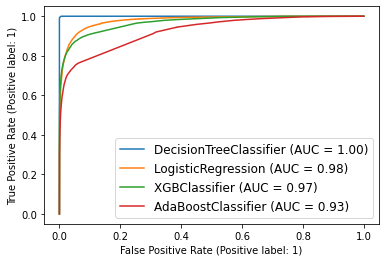

In [41]:
# model work on training data

disp =plot_roc_curve(dt,x_train,y_train)

plot_roc_curve(lr,x_train,y_train,ax=disp.ax_) 

plot_roc_curve(xgb,x_train,y_train,ax=disp.ax_)

plot_roc_curve(ada,x_train,y_train,ax=disp.ax_)

plt.legend(prop={'size':12},loc='lower right')

plt.show()

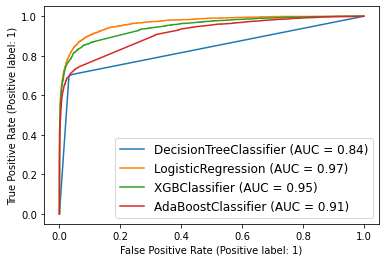

In [42]:
# model work on testing data

disp =plot_roc_curve(dt,x_test,y_test)

plot_roc_curve(lr,x_test,y_test,ax=disp.ax_) 

plot_roc_curve(xgb,x_test,y_test,ax=disp.ax_)

plot_roc_curve(ada,x_test,y_test,ax=disp.ax_)

plt.legend(prop={'size':12},loc='lower right')

plt.show()